In [135]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

from tcia_utils import nbia
import sys
!{sys.executable} -m pip install --upgrade -q tcia_utils
import json

import requests
import configparser
config = configparser.ConfigParser()
config.read("../config.ini")

from concurrent.futures import ThreadPoolExecutor

import random
import openslide
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.cluster import KMeans

# Prepare 2 WSI examples

In [ ]:
# Function to query the GDC API for slide files associated with a submitter_id
def query_gdc_api(submitter_id):
    files_endpt = "https://api.gdc.cancer.gov/files"
    filters = {
        "op": "and",
        "content": [
            {
                "op": "in",
                "content": {
                    "field": "cases.submitter_id",
                    "value": [submitter_id]
                }
            },
            {
                "op": "in",
                "content": {
                    "field": "files.data_format",
                    "value": ["SVS"]
                }
            }
        ]
    }
    params = {
        "filters": json.dumps(filters),
        "fields": "file_id,file_name",
        "format": "JSON",
        "size": "100"
    }
    response = requests.get(files_endpt, params=params)
    if response.status_code == 200:
        return response.json()["data"]["hits"]
    else:
        print(f"Error querying GDC API: {response.status_code}")
        return []

# Function to download a file from the GDC API using its file_id
def download_slide(file_id, file_name, download_dir):
    data_endpt = f"https://api.gdc.cancer.gov/data/{file_id}"
    response = requests.get(data_endpt, stream=True)
    if response.status_code == 200:
        file_path = os.path.join(download_dir, file_name)
        with open(file_path, "wb") as output_file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    output_file.write(chunk)
        print(f"Downloaded {file_name}")
    else:
        print(f"Error downloading {file_name}: {response.status_code}")

# Main function to execute the download process
def main(submitter_id, download_dir, num_slides=5):
    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)

    # Query the GDC API for slide files
    slides = query_gdc_api(submitter_id)

    if not slides:
        print("No slides found for the given submitter_id.")
        return

    # Randomly select the specified number of slides
    selected_slides = random.sample(slides, min(num_slides, len(slides)))

    # Download each selected slide
    for slide in selected_slides:
        download_slide(slide["file_id"], slide["file_name"], download_dir)

subject_id = config["examples"]["subject_2"]
if __name__ == "__main__":
    download_dir = r"D:\data\wsi_slides\examples_2_patient" 
    main(subject_id, download_dir) 
    
# more than 40 minutes to download 2 SVS files, especially the second one


Downloaded TCGA-B8-A54E-01A-01-TS1.287E393E-BE65-46F4-BB17-171DC9E825B1.svs
Downloaded TCGA-B8-A54E-01Z-00-DX1.336165F7-BBAC-4FA8-B776-E12483C60B62.svs


Available levels and their dimensions: ((91392, 21773), (22848, 5443), (5712, 1360), (2856, 680))
Image dimensions at level 0: (91392, 21773)


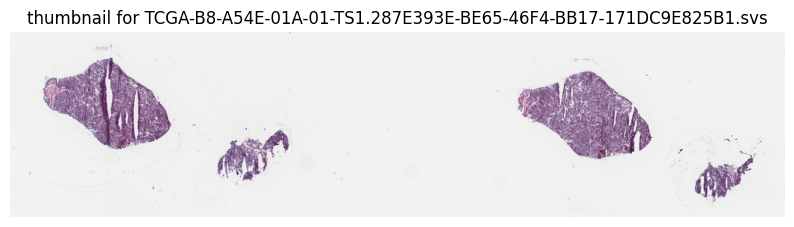

Available levels and their dimensions: ((185639, 68935), (46409, 17233), (11602, 4308), (2900, 1077))
Image dimensions at level 0: (185639, 68935)


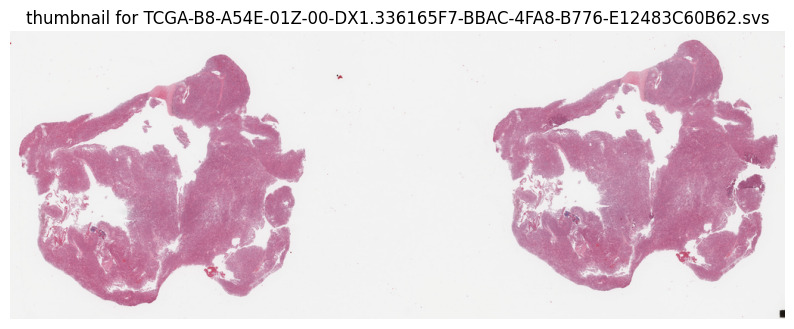

In [27]:
level = 0

file_path_1 = config["wsi"]["wsi_slides"] + r'examples_1_patient/TCGA-B8-A54E-01A-01-TS1.287E393E-BE65-46F4-BB17-171DC9E825B1.svs'
file_path_2 = config["wsi"]["wsi_slides"] + r'examples_1_patient/TCGA-B8-A54E-01Z-00-DX1.336165F7-BBAC-4FA8-B776-E12483C60B62.svs'

for file_path in [file_path_1, file_path_2]:
    try:
        slide = openslide.OpenSlide(file_path)
        levels = slide.level_dimensions
        print(f"Available levels and their dimensions: {levels}")
        if level >= len(levels):
            raise ValueError(f"level {level} is not valid. available levels: {len(levels)}.")

        # Get the dimensions of the specified level
        dimensions = levels[level]
        print(f"Image dimensions at level {level}: {dimensions}")

        # Generate a thumbnail for easier visualization if the level is too large
        if dimensions[0] > 20000 or dimensions[1] > 20000:  # Arbitrary threshold
            thumbnail = slide.get_thumbnail((1024, 1024))  # Resize to 1024x1024
            plt.figure(figsize=(10, 10))
            plt.imshow(thumbnail)
            plt.axis("off")
            plt.title(f"thumbnail for {file_path.split('/')[-1]}")
            plt.show()
        else:
            # Read the ROI at the specified level
            region = slide.read_region((0, 0), level, dimensions)
            plt.figure(figsize=(10, 10))
            plt.imshow(region)
            plt.axis("off")
            plt.title(f"WSI: {file_path.split('/')[-1]} (Level {level})")
            plt.show()

    except Exception as e:
        print(f"Error displaying WSI: {e}")

## Extract tissue part - Otsu's method

Available levels and their dimensions: ((185639, 68935), (46409, 17233), (11602, 4308), (2900, 1077))
width and height at chosen level 2: 11602 4308


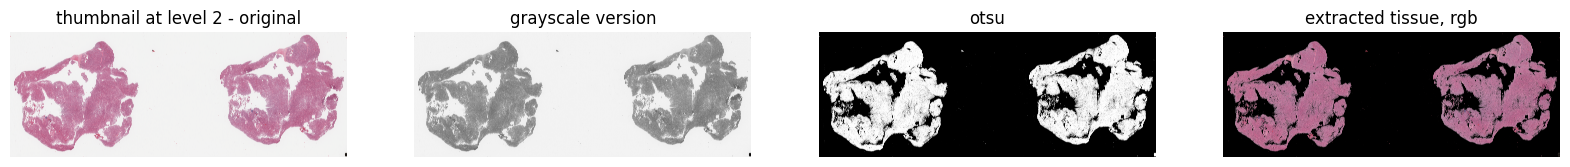

In [ ]:
slide = openslide.OpenSlide(file_path_2)
print("Available levels and their dimensions:", slide.level_dimensions)

level = 2  # resolution level
w, h = slide.level_dimensions[level]
print(f"width and height at chosen level {level}:", w, h)

# read the downsampled image
thumbnail = slide.read_region((0, 0), level, (w, h))
thumbnail = thumbnail.convert("RGB")  # convert from PIL format to RGB
image_rgb = np.array(thumbnail) # convert to numpy array

# Otsu's
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY) # get the grayscale version
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# invert the binary mask (so tissue is white and background is black)
binary_inv = cv2.bitwise_not(binary)

# apply the mask to extract tissue while keeping original colors
extracted_tissue = cv2.bitwise_and(image_rgb, image_rgb, mask=binary_inv)


fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(image_rgb)  
ax[0].set_title(f"thumbnail at level {level} - original")
ax[0].axis("off")

ax[1].imshow(gray, cmap="gray")
ax[1].set_title("grayscale version")
ax[1].axis("off")

ax[2].imshow(binary_inv, cmap="gray")
ax[2].set_title("otsu")
ax[2].axis("off")

ax[3].imshow(extracted_tissue)
ax[3].set_title("extracted tissue, rgb")
ax[3].axis("off")

plt.show()

# level 1 crashes, level 2 is faster (20s)

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

subject1_filepath2 = config["wsi"]["wsi_slides"] + r'examples_1_patient/TCGA-B8-A54E-01Z-00-DX1.336165F7-BBAC-4FA8-B776-E12483C60B62.svs'
subject1_id = config["examples"]["subject_1"]
subject1_filepath2_patches = config["wsi"]["wsi_slides"] + r"examples_1_patient/patches"
num_patches = 4000  # arbitrary, #TODO


Path(output_folder).mkdir(parents=True, exist_ok=True)

slide = openslide.OpenSlide(subject1_filepath2)
level = 2   #TODO

thumbnail = slide.read_region((0, 0), level, slide.level_dimensions[level])
thumbnail = thumbnail.convert("RGB") # convert from PIL format to RGB
thumbnail_np = np.array(thumbnail) # convert to numpy array

# otsu's
gray = cv2.cvtColor(thumbnail_np, cv2.COLOR_RGB2GRAY)
_, tissue_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# invert mask so tissue = white (255), background = black (0)
tissue_mask = cv2.bitwise_not(tissue_mask)


#############################################  
#### zooming patches to the tissue mask #####
#############################################

# use scale factor instead of resizing (avoid memory error)
scale_factor = slide.level_downsamples[level]  
mask_coords = np.column_stack(np.where(tissue_mask > 0))  # (y, x) positions at level 2

# map mask coordinates to level 0 size (20X magnification)
scaled_coords = [(int(y * scale_factor), int(x * scale_factor)) for y, x in mask_coords]
print("scaled_coords, first 5 coords", scaled_coords[:5])  

# randomly sample coordinates for patches
sampled_coords = random.sample(scaled_coords, min(num_patches, len(scaled_coords)))

# patch size at 20X
patch_size = 500  

# collect/save patches
for i, (y, x) in enumerate(tqdm(sampled_coords, desc="extracting patches")):
    # read the patch from the slide
    patch = slide.read_region((x, y), 0, (patch_size, patch_size))  
    patch = patch.convert("RGB")   # convert from PIL format to RGB
    patch_filename = f"{subject1_filepath2_patches}/{subject1_id}_{y}_{x}.png"
    patch.save(patch_filename, "PNG")

slide.close()

print(f"saved {len(sampled_coords)} patches in {subject1_filepath2_patches}")

scaled_coords, first 5 coords [(80, 26977), (80, 26993), (96, 26977), (96, 26993), (96, 27009)]


extracting patches: 100%|██████████| 5000/5000 [04:28<00:00, 18.63it/s]

saved 5000 patches in D:/data/wsi_slides/examples_1_patient/patches


# Pretrained, feature extraction

- A folder of patches
- A patch = a vector of features extracted using VGG19 or etc
- Clustering KMeans (K=10, etc) on these features vectors


In [185]:
from torchvision.models import vgg19, VGG19_Weights
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [189]:
#############################################
### data loader for the extracted patches ###
#############################################
class PatchDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.files = [os.path.join(self.folder, f) for f in os.listdir(folder)
                      if os.path.isfile(os.path.join(self.folder, f))]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # convert from BGR to RGB
        image = cv2.imread(self.files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        # return image object and filename
        filename = self.files[idx].split("\\")[-1]
        return image, filename


#############################################
### define transforms for VGG19 input #######
#############################################

# VGG19 expects 224x224 images and ImageNet normalization # TODO
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])


patch_folder = r"D:\data\wsi_slides\examples_1_patient\patches"
dataset = PatchDataset(patch_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
#############################################
####### load pre-trained VGG19 model ########
#############################################
# pretrained imagenet
model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
model.to(device)
# no need to train, use the current weights to extract features
model.eval()  

In [193]:
#############################################
### extract features for each patch ##########
#############################################
# want to extract a feature vector rather than classification scores.
# thus, build a new Sequential model that goes through
# 1. model.features (convolutional part)
# 2. model.avgpool (adaptive avg pooling)
# 3. flatten (convert a tensor to a vector)
# 4. model.classifier = False 
# result is a some-dimensional feature vector for each patch image

feature_extractor = torch.nn.Sequential(
    model.features,
    model.avgpool,
    torch.nn.Flatten(),
    *list(model.classifier.children())[:-1] # remove the last layer
).to(device)

In [194]:
patches_features = {}
check_count = 0

with torch.no_grad():
    for image, file_name in tqdm(dataloader):

        image = image.to(device)
        
        features = feature_extractor(image)  
        # to numpy array
        features = features.squeeze(0).cpu().numpy()  
        
        patches_features[file_name[0]] = features

100%|██████████| 5000/5000 [04:32<00:00, 18.37it/s]


# Clustering

In [201]:
no_clusters = 5

kmeans = KMeans(n_clusters=no_clusters, random_state=0, n_init=50)
cluster_ids = kmeans.fit_predict(list(patches_features.values()))

patches_clusters = {(int(f.split("_")[1]), int(f.split("_")[2].split(".")[0])): c # (y, x): cluster
                    for f, c in zip(patches_features.keys(), cluster_ids)}

# Visual

In [180]:
import matplotlib.patches as patches

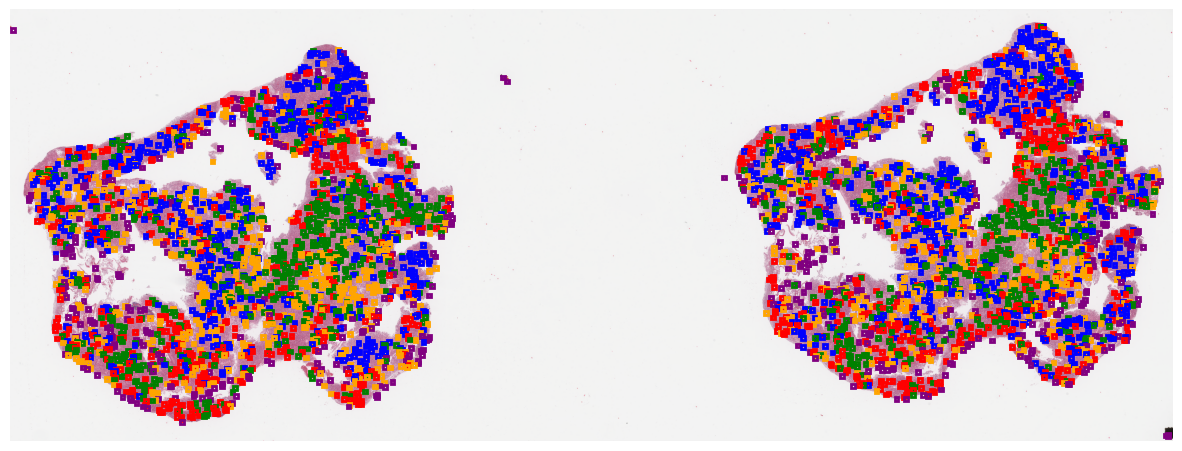

In [202]:
svs_original_path_2 = file_path_2
slide = openslide.OpenSlide(svs_original_path_2)


level = 2
level_dims = slide.level_dimensions[level]  
full_dims = slide.level_dimensions[0]        

img = slide.read_region((0, 0), level, level_dims).convert("RGB")

# compute scale factors from full resolution to the chosen level
scale_x = level_dims[0] / full_dims[0]
scale_y = level_dims[1] / full_dims[1]

# set the patch size in full resolution
# should match how patches were extracted
patch_size = 600  

# colors for the clusters.
colors = ['red', 'blue', 'green', 'orange', 'purple', 
          'yellow', 'pink', 'cyan', 'magenta', 'lime']

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img)


for coord, cluster in patches_clusters.items():
    try:
        y_full, x_full = coord[0], coord[1]
    except Exception as e:
        print(f"skip coord {x_full, y_full} due to error: {e}")
        continue

    # scale the coordinates to the visualization level=2
    x_vis = x_full * scale_x
    y_vis = y_full * scale_y
    patch_size_vis = patch_size * scale_x  # isotropic scaling

    # 500x500 patch with the color of that cluster
    rect = patches.Rectangle(
        (x_vis, y_vis), patch_size_vis, patch_size_vis,
        linewidth=2,
        edgecolor=colors[cluster % len(colors)],  
        facecolor='none'
    )
    ax.add_patch(rect)

plt.axis('off')
plt.show()


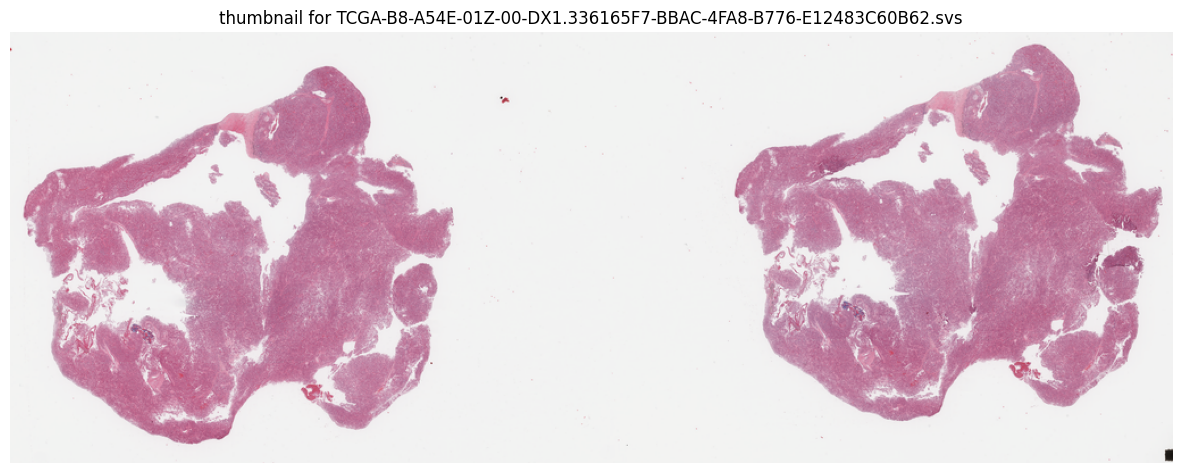

In [204]:
level = 0

file_path_1 = config["wsi"]["wsi_slides"] + r'examples_1_patient/TCGA-B8-A54E-01A-01-TS1.287E393E-BE65-46F4-BB17-171DC9E825B1.svs'
file_path_2 = config["wsi"]["wsi_slides"] + r'examples_1_patient/TCGA-B8-A54E-01Z-00-DX1.336165F7-BBAC-4FA8-B776-E12483C60B62.svs'

for file_path in [file_path_2]:
    try:
        slide = openslide.OpenSlide(file_path)
        levels = slide.level_dimensions
        # print(f"Available levels and their dimensions: {levels}")
        if level >= len(levels):
            raise ValueError(f"level {level} is not valid. available levels: {len(levels)}.")

        # Get the dimensions of the specified level
        dimensions = levels[level]
        # print(f"Image dimensions at level {level}: {dimensions}")

        # Generate a thumbnail for easier visualization if the level is too large
        if dimensions[0] > 20000 or dimensions[1] > 20000:  # Arbitrary threshold
            thumbnail = slide.get_thumbnail((1024, 1024))  # Resize to 1024x1024
            plt.figure(figsize=(15, 15))
            plt.imshow(thumbnail)
            plt.axis("off")
            plt.title(f"thumbnail for {file_path.split('/')[-1]}")
            plt.show()
        else:
            # Read the ROI at the specified level
            region = slide.read_region((0, 0), level, dimensions)
            plt.figure(figsize=(15, 15))
            plt.imshow(region)
            plt.axis("off")
            plt.title(f"WSI: {file_path.split('/')[-1]} (Level {level})")
            plt.show()

    except Exception as e:
        print(f"Error displaying WSI: {e}")